In [1]:
import numpy as np
import clfanalysis
from clfanalysis.preamble import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy

def cm2inch(cm):
    return cm / 2.54

from clfanalysis.preprocess import rescale, greyscale
from clfanalysis.globalparams import n_repeats, cv, N_ITER, loadpath, datafiles
from clfanalysis.noisecorrections import get_noise_estimates, analyse_confusion_matrix_list

In [2]:
clf_flags = ['lr', 'rf', 'mlp']
data_flags = [0, 1]
estimatortypes = ['bare', 'tf', 'estf']
data_fields = ['mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score', 'cv_test_score', 'cv_train_score', 'best_model_list', 'class_prob_list', 'rho_minus_list', 'rho_plus_list', 'runtimes']

for clf_flag in clf_flags:
    
    for data_flag in data_flags:
        vars()[clf_flag+str(data_flag)] = np.load(clf_flag+'_'+str(data_flag)+'.npz')

### Fig 1: Data Processing

In [3]:
for data_flag in data_flags:

    # load data:
    dataset = np.load(loadpath+datafiles[data_flag]+'.npz')

    # for MINST
    if data_flag == 1: 
        Xtr_m = dataset['Xtr']
        Xtr_1 = rescale(Xtr_m)

    # for CIFAR
    if data_flag == 0: 
        Xtr = dataset['Xtr']
        Xtr_0 = np.asarray([greyscale(np.transpose(Xtr[sample, :].reshape(3, 32, 32), (1, 2, 0))) for sample in range(10000)])
        Xtr_0r = rescale(Xtr_0.reshape(10000, 32*32))

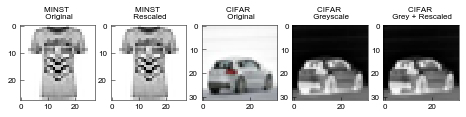

In [4]:
pickimage = np.random.randint(low=0, high=1000, size=1)

fig = plt.figure(figsize=(cm2inch(20), cm2inch(4.5)))

ax = fig.add_subplot(1, 5, 1)
ax.set_title('MINST \n Original', fontsize=8)
ax.imshow(Xtr_m[pickimage, :].reshape(28, 28), cmap='Greys', vmin=0, vmax=255)

ax = fig.add_subplot(1, 5, 2)
ax.set_title('MINST \n Rescaled', fontsize=8)
ax.imshow(Xtr_1[pickimage, :].reshape(28, 28), cmap='Greys', vmin=0, vmax=1)

ax = fig.add_subplot(1, 5, 3)
ax.set_title('CIFAR \n Original',  fontsize=8)
ax.imshow(np.transpose(Xtr[pickimage, :].reshape(3, 32, 32), (1, 2, 0)))

ax = fig.add_subplot(1, 5, 4)
ax.set_title('CIFAR \n Greyscale', fontsize=8)
ax.imshow(Xtr_0[pickimage, :, :].reshape(32, 32), cmap='Greys', vmin=0, vmax=255)

ax = fig.add_subplot(1, 5, 5)
ax.set_title('CIFAR \n Grey + Rescaled', fontsize=8)
ax.imshow(Xtr_0r[pickimage, :].reshape(32, 32), cmap='Greys', vmin=0, vmax=1)

plt.savefig('fig_dataprocessing', format='svg', dpi=400)
plt.show() 

###  Eigenspectra for CIFAR and MINST

/home/riddhisw/anaconda2/envs/QISKitenv/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


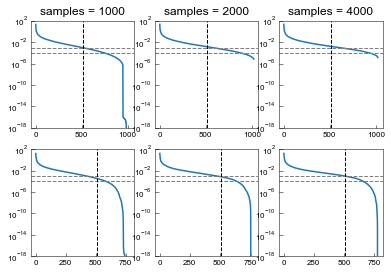

In [26]:
# randomly select 10%, 20%, and 40% of data to study eigenvalues and estimate kdims

sample_list = [1000, 2000, 4000]
data_set_processed = [Xtr_0r, Xtr_1]

fig = plt.figure(figsize=(cm2inch(16), cm2inch(11)))

for idx_imgset in range(2):
    
    for idx_eig in range(3):
        
        imagebase = data_set_processed[idx_imgset]
        pick_subset = np.random.randint(low=0, high=10000, size=sample_list[idx_eig]) 
        cov = np.cov((imagebase[pick_subset] - np.mean(imagebase[pick_subset], axis=0)).T)
        eigenvalues = np.linalg.eigvals(cov)
        
        ax = fig.add_subplot(2, 3, idx_imgset*3 + idx_eig + 1)
        if idx_imgset ==0:
            ax.set_title('samples = %s' %(sample_list[idx_eig]))

        ax.plot(np.sort(eigenvalues)[::-1])
        ax.axhline(y=10**(-3), c='grey', lw=1.0, ls='--')
        ax.axhline(y=10**(-4), c='grey', lw=1.0, ls='--')
        ax.axvline(x=512, c='k', lw=1.0, ls='--')
        # ax.axvline(x=768, c='k', lw=1.0, ls='--')
        ax.set_yscale('log'),
        ax.set_ylim([10**(-18), 10**2])
plt.savefig('fig_eigenspace.svg', format='svg', dpi=400)
plt.show()

### Fig 2:  Mean Accuracy Score

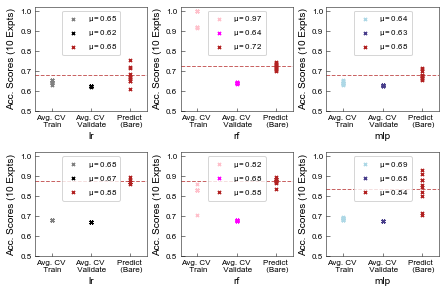

In [19]:
x_train = np.zeros(n_repeats)
x_test = np.ones(n_repeats)
x_predict = 2*np.ones(n_repeats)

gs = gridspec.GridSpec(2, 3, top=0.95, left=0.1, right=0.99, bottom=0.15, wspace=0.3, hspace=0.4 )
fig = plt.figure(figsize=(cm2inch(16), cm2inch(11)))
size=10
idx_row=0

trainlist = ['gray', 'pink', 'lightblue']
validatelist = ['k', 'magenta', 'darkslateblue']

for clf_flag in clf_flags:

    for idx_col in data_flags:

        ax = fig.add_subplot(gs[idx_col, idx_row])
        
        ax.scatter(x_train, vars()[clf_flag+str(idx_col)]["mean_train_score"], 
                   c=trainlist[idx_row], s=size, marker='x',
                   label=r'$\mu=$%s' %(np.round(np.mean(vars()[clf_flag+str(idx_col)]["mean_train_score"]), 2)))
        
        ax.scatter(x_test, vars()[clf_flag+str(idx_col)]["mean_test_score"], 
                   c=validatelist[idx_row], s=size, marker='x',
                   label=r'$\mu=$%s' %(np.round(np.mean(vars()[clf_flag+str(idx_col)]["mean_test_score"]), 2)))
        
        y_mean = np.mean(vars()[clf_flag+str(idx_col)]["acc_bare"])
        ax.scatter(x_predict, vars()[clf_flag+str(idx_col)]["acc_bare"], 
                   c='firebrick', s=size, marker='x', 
                   label=r'$\mu=$%s' %(np.round( y_mean, 2)))
        ax.axhline(y=y_mean, ls='--', c='firebrick', lw=1.0, alpha=0.7)
        
        ax.set(xlabel=clf_flag, ylabel='Acc. Scores (10 Expts)')
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['Avg. CV \n Train', 'Avg. CV \n Validate', 'Predict \n (Bare)'])
        ax.set_ylim([0.5, 1.02])
        ax.legend(loc=9, fontsize=8)
        plt.margins(0.2)
    
    idx_row +=1

plt.savefig('fig_bare_case', format='svg', dpi=400)

plt.show()

### Fig 3: Importance Re-Weighting for LR and RF

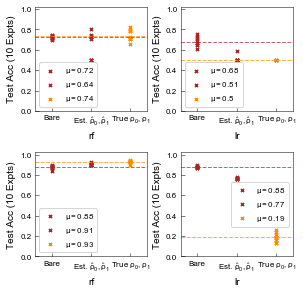

In [13]:
x_tf = 4*np.ones(n_repeats)
x_estf = 3*np.ones(n_repeats)

gs = gridspec.GridSpec(2, 3, top=0.95, left=0.1, right=0.99, bottom=0.15, wspace=0.3, hspace=0.4 )
fig = plt.figure(figsize=(cm2inch(16), cm2inch(11)))
size=10
idx_row=0
for clf_flag in ['rf', 'lr']:

    for idx_col in data_flags:

        ax = fig.add_subplot(gs[idx_col, idx_row])
        
        y_mean = np.mean(vars()[clf_flag+str(idx_col)]["acc_bare"])
        ax.scatter(x_predict, vars()[clf_flag+str(idx_col)]["acc_bare"], 
                   c='firebrick', s=size, marker='x', 
                   label=r'$\mu=$%s' %(np.round( y_mean, 2)))
        ax.axhline(y=y_mean, ls='--', c='firebrick', lw=1.0, alpha=0.7)
        
        y_mean = np.mean(vars()[clf_flag+str(idx_col)]["acc_estf"])
        ax.scatter(x_estf, vars()[clf_flag+str(idx_col)]["acc_estf"], 
                   c='brown', s=size, marker='x', 
                   label=r'$\mu=$%s' %(np.round( y_mean, 2)))
        # ax.axhline(y=y_mean, ls='--', c='brown', lw=1.0, alpha=0.7)
        
        y_mean = np.mean(vars()[clf_flag+str(idx_col)]["acc_tf"])
        ax.scatter(x_tf, vars()[clf_flag+str(idx_col)]["acc_tf"], 
                   c='darkorange', s=size, marker='x', 
                   label=r'$\mu=$%s' %(np.round( y_mean, 2)))
        ax.axhline(y=y_mean, ls='--', c='darkorange', lw=1.0, alpha=0.7)
        

        
        ax.set(xlabel=clf_flag, ylabel='Test Acc (10 Expts)')
        ax.set_xticks([2, 3, 4])
        ax.set_xticklabels(['Bare', r'Est. $\hat{\rho}_0, \hat{\rho}_1$', r'True $\rho_0, \rho_1$'])
        ax.set_ylim([0.0, 1.02])
        ax.legend(loc=0, fontsize=8)
        plt.margins(0.2)
    
    idx_row +=1
    

#     for idx_col in data_flags:

#         ax = fig.add_subplot(gs[idx_col, 2])
        
#         ax.scatter(np.zeros(n_repeats), vars()['rf'+str(idx_col)]["rho_minus_list"], 
#            c='grey', s=size, marker='v')
#            #label=r'$\mu=$%s' %(np.round( y_mean, 2)))
        
#         ax.scatter(np.ones(n_repeats), vars()['rf'+str(idx_col)]["rho_plus_list"], 
#            c='grey', s=size, marker='*')
#            #label=r'$\mu=$%s' %(np.round( y_mean, 2)))
            
#         ax.set_xticks([0, 1])
#         ax.set_xticklabels([r'Est. $\hat{\rho}_0$', r'Est. $\hat{\rho}_1$',])
#         ax.set_ylim([-0.05, 0.45])
#         ax.set(xlabel='rf', ylabel=r'Est. $\rho$ rates')
#         plt.margins(0.2)
        
plt.savefig('fig_ir_case', format='svg', dpi=400)

plt.show()

### Fig 4: Noise Flip Rates Estimation

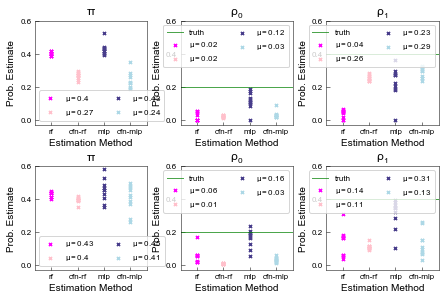

In [7]:
x_rf = np.zeros(n_repeats) # rf
x_lr = np.ones(n_repeats) # lr 
x_mpl = 2*np.ones(n_repeats) # mpl
x_cfn = 3*np.ones(n_repeats) # confusion matrix from one of the classifiers



noise_flags = ['pi_list', 'rho_minus_list', 'rho_plus_list']
noise_truths = [None, 0.2, 0.4]
colorlist = ['magenta', 'pink', 'darkslateblue', 'lightblue']
noise_titles = [r'$\pi$', r'$\rho_0$', r'$\rho_1$']

gs = gridspec.GridSpec(2, 3, top=0.95, left=0.1, right=0.99, bottom=0.15, wspace=0.3, hspace=0.4 )



fig = plt.figure(figsize=(cm2inch(16), cm2inch(11)))
size=10
idx_row=0


for n_flag in noise_flags:

    for idx_col in data_flags:

        ax = fig.add_subplot(gs[idx_col, idx_row])

        clf_counter = 0 
        for clf_flag in ['rf', 'mlp']:

            # Flip Rate Estimator

            ax.scatter(np.ones(n_repeats)*clf_counter*2, vars()[clf_flag+str(idx_col)][n_flag], 
                       c=colorlist[clf_counter*2], s=size, marker='x',
                       label=r'$\mu=$%s' %(np.round(np.mean(vars()[clf_flag+str(idx_col)][n_flag]), 2)))

            # Flip Rate via Confusion Matrix 

            cmatrix_list = vars()[clf_flag+str(idx_col)]["cmatrix_list"].reshape(10,2,2)
            cfn_data = analyse_confusion_matrix_list(cmatrix_list)
            
            ax.scatter(np.ones(n_repeats)*(clf_counter*2 + 1), cfn_data[:, idx_row], 
                   c=colorlist[(clf_counter*2 + 1)], s=size, marker='x',
                   label=r'$\mu=$%s' %(np.round(np.mean(cfn_data[:, idx_row]),2)))

            clf_counter +=1

        if idx_row != 0:
            ax.axhline(y=noise_truths[idx_row], ls='-', c='green', lw=1.0, alpha=0.7, label='truth')


        ax.set_ylim([-0.03, 0.6])
        ax.set(title=noise_titles[idx_row], xlabel='Estimation Method', ylabel='Prob. Estimate')
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(['rf', 'cfn-rf', 'mlp', 'cfn-mlp'])
        ax.legend(loc=0, fontsize=8, ncol=2)
        plt.margins(0.2)

    idx_row +=1

plt.savefig('fig_fliprates_comparison', format='svg', dpi=400)

plt.show()

### Fig 5: Run Times

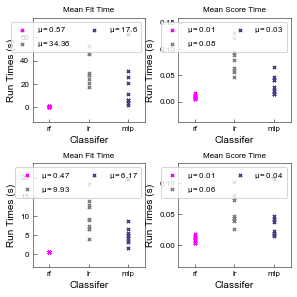

In [12]:
x_rf = np.zeros(n_repeats) # rf
x_lr = np.ones(n_repeats) # lr 
x_mpl = 2*np.ones(n_repeats) # mpl
x_cfn = 3*np.ones(n_repeats) # confusion matrix from one of the classifiers



time_flags = ['mean_fit_time', 'mean_score_time']
colorlist = ['magenta', 'grey', 'darkslateblue']*3
noise_titles = ['Mean Fit Time', 'Mean Score Time']

gs = gridspec.GridSpec(2, 3, top=0.95, left=0.1, right=0.99, bottom=0.15, wspace=0.3, hspace=0.4 )


fig = plt.figure(figsize=(cm2inch(16), cm2inch(11)))
size=10
idx_row=0


for t_flag in time_flags:

    for idx_col in data_flags:

        ax = fig.add_subplot(gs[idx_col, idx_row])

        clf_counter = 0 
        for clf_flag in ['lr', 'rf', 'mlp']:

            ax.scatter(np.ones(n_repeats)*clf_counter, vars()[clf_flag+str(idx_col)][t_flag], 
                       c=colorlist[clf_counter], s=size, marker='x',
                       label=r'$\mu=$%s' %(np.round(np.mean(vars()[clf_flag+str(idx_col)][t_flag]), 2)))

            clf_counter +=1

        #ax.set_ylim([-0.03, 0.6])
        ax.set_title(noise_titles[idx_row], fontsize=8)
        ax.set(xlabel='Classifer', ylabel='Run Times (s)')
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['rf', 'lr', 'mlp'])
        ax.legend(loc=0, fontsize=8, ncol=2)
        plt.margins(0.2)

    idx_row +=1

plt.savefig('fig_runtimes', format='svg', dpi=400)

plt.show()